# CECAM MDAnalysis Workshop: Prototype


In [1]:
import os.path

In [73]:
import MDAnalysis as mda
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
mda.__version__

'0.12.1-dev'

## Cleanup of trajectories 

The original trajectories were converted from the Anton format and in thge conversion process, the time information was garbled (dt = 240 ps between frames) so I am rewriting the trajectories with this information properly added (needs MDAnalysis 0.12.0):

In [46]:
datadir = os.path.join("..", "sandbox")
PSF = os.path.join(datadir, "equilibrium", "adk4AKE.psf")
DCD1 = os.path.join(datadir, "equilibrium", "1ake_007-nowater-core.dcd") 
DCD2 = os.path.join(datadir, "equilibrium", "1ake_009-nowater-core.dcd") 

In [49]:
def cleanup_dcd(dcd, psf=PSF, timeunit="ps", lengthunit="Angstrom", dt=240.):
    u = mda.Universe(PSF, dcd, format="LAMMPS", 
                     timeunit=timeunit, lengthunit=lengthunit, dt=240)
    fn, ext = os.path.splitext(dcd)
    pth = "{0}-dt{1:.0f}{2}{3}".format(fn, dt, timeunit, ext)
    print("Writing {}".format(pth))
    with u.trajectory.OtherWriter(pth) as W:
        for ts in u.trajectory:
            W.write(ts)
    return pth

In [50]:
cleanup_dcd(DCD1)

Writing ../sandbox/equilibrium/1ake_007-nowater-core-dt240ps.dcd


'../sandbox/equilibrium/1ake_007-nowater-core-dt240ps.dcd'

In [51]:
cleanup_dcd(DCD2)

Writing ../sandbox/equilibrium/1ake_009-nowater-core-dt240ps.dcd


'../sandbox/equilibrium/1ake_009-nowater-core-dt240ps.dcd'

## Testing of cleaned up trajectories 

In [52]:
datadir = os.path.join("..", "sandbox")
PSF = os.path.join(datadir, "equilibrium", "adk4AKE.psf")
DCD1 = os.path.join(datadir, "equilibrium", "1ake_007-nowater-core-dt240ps.dcd") 
DCD2 = os.path.join(datadir, "equilibrium", "1ake_009-nowater-core-dt240ps.dcd") 

In [53]:
u = mda.Universe(PSF, DCD1)

In [55]:
u.trajectory.dt

240.00000489999024

## Angle collective variables
Define the NMP-CORE and LID-CORE angles:

In [56]:
import numpy as np
from numpy.linalg import norm

def theta_NMP(u):
    """Calculate the NMP-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 115:125 and (backbone or name CB)").center_of_geometry()
    B = u.select_atoms("resid 90:100 and (backbone or name CB)").center_of_geometry()
    A = u.select_atoms("resid 35:55 and (backbone or name CB)").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

def theta_LID(u):
    """Calculate the LID-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 179:185 and (backbone or name CB)").center_of_geometry()
    B = u.select_atoms("resid 115:125 and (backbone or name CB)").center_of_geometry()
    A = u.select_atoms("resid 125:153 and (backbone or name CB)").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

Plot trajectory in angle-angle space:

In [123]:
def angle_plot(data, filename="NMP_LID_angle_projection", start=None, stop=None, step=None):   
    time, NMP, LID = data[start:stop:step].T
    
    degreeFormatter = matplotlib.ticker.FormatStrFormatter(r"%g$^\circ$")
    nsFormatter = matplotlib.ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x/1000.))
    fig = plt.figure(figsize=(6,3))

    ax1 = fig.add_subplot(121)
    ax1.plot(time, NMP, 'b-', lw=2, label=r"$\theta_{\mathrm{NMP}}$")
    ax1.plot(time, LID, 'r-', lw=2, label=r"$\theta_{\mathrm{LID}}$")
    ax1.set_xlabel(r"time $t$ (ns)")
    ax1.set_ylabel(r"angle $\theta$")
    ax1.xaxis.set_major_formatter(nsFormatter)
    ax1.yaxis.set_major_formatter(degreeFormatter)
    ax1.legend(loc="best")

    ax2 = fig.add_subplot(122)
    ax2.plot(NMP, LID, 'k-', lw=1)
    ax2.set_xlabel(r"NMP-CORE angle $\theta_{\mathrm{NMP}}$")
    ax2.set_ylabel(r"LID-CORE angle $\theta_{\mathrm{LID}}$")
    ax2.xaxis.set_major_formatter(degreeFormatter)
    ax2.yaxis.set_major_formatter(degreeFormatter)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    fig.subplots_adjust(left=0.12, right=0.88, bottom=0.2, wspace=0.15)

    for ext in ('svg', 'pdf', 'png'):
        fig.savefig("{0}.{1}".format(filename, ext))


### Dynamic importance sampling (DIMS) MD
DIMS MD introduces a dynamic bias to generate a transition between an inital and a final conformation. Here the transition is between closed Adk (pdb 1AKE) and open AdK (4AKE).

In [157]:
datadir = os.path.join("..", "sandbox")
PSFdims = os.path.join(datadir, "dims", "adk4ake.psf")
coDIMS = [os.path.join(datadir, "dims", "dims_co_{0:03n}.dcd".format(i)) for i in range(1,4)] 
ocDIMS = [os.path.join(datadir, "dims", "dims_oc_{0:03n}.dcd".format(i)) for i in range(1,4)] 

In [158]:
coDIMS

['../sandbox/dims/dims_co_001.dcd',
 '../sandbox/dims/dims_co_002.dcd',
 '../sandbox/dims/dims_co_003.dcd']

In [160]:
u = mda.Universe(PSFdims, coDIMS[0])

Iterate through the trajectory and collect the data:

In [161]:
data = np.array([[ts.time, theta_NMP(u), theta_LID(u)] for ts in u.trajectory])

Plot the data:

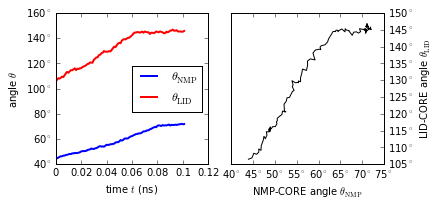

In [162]:
angle_plot(data)

### Equilibrium MD 

In [148]:
datadir = os.path.join("..", "sandbox")
PSF = os.path.join(datadir, "equilibrium", "adk4AKE.psf")
DCD1 = os.path.join(datadir, "equilibrium", "1ake_007-nowater-core-dt240ps.dcd") 
DCD2 = os.path.join(datadir, "equilibrium", "1ake_009-nowater-core-dt240ps.dcd") 

#### Trajectory 1 

In [138]:
u1 = mda.Universe(PSF, DCD1)

In [139]:
theta_NMP(u1), theta_LID(u1)

(51.658489, 113.34765)

In [140]:
u1.trajectory.n_frames

4187

Iterate through the trajectory and collect the data. Using the whole trajectory can take a while so you might first want to experiment with slicing (e.g. `u.trajectory[::100]`or `u.trajectory[:100]`):

In [141]:
data1 = np.array([[ts.time, theta_NMP(u1), theta_LID(u1)] for ts in u1.trajectory])

Plot of all data (a bit messy, try slices of the trajectory where the angles change most).

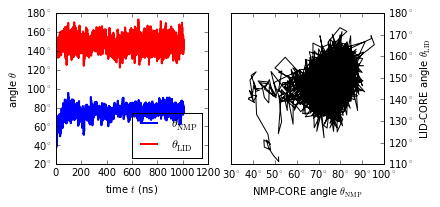

In [142]:
angle_plot(data1)

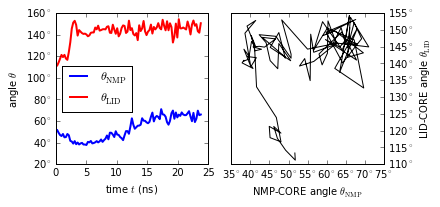

In [143]:
angle_plot(data1, stop=100)

#### Trajectory 2

In [128]:
u2 = mda.Universe(PSF, DCD2)

In [132]:
u2.trajectory.n_frames

4187

In [133]:
data2 = np.array([[ts.time, theta_NMP(u2), theta_LID(u2)] for ts in u2.trajectory])

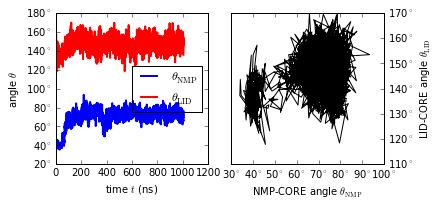

In [137]:
angle_plot(data2)

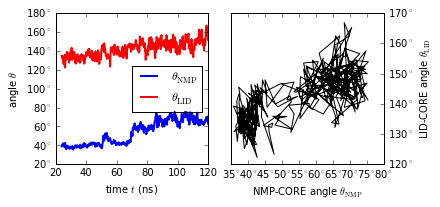

In [147]:
angle_plot(data2, start=100, stop=500)